In [1]:
from stochastic_volatility_models.src.models.heston.heston import Heston
from notebook_utils import Notebook

2024-08-09 13:28:28.789 | INFO     | stochastic_volatility_models.config:initialise:30 - Loaded module `stochastic_volatility_models` from project directory path `/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules`


In [2]:
nb = Notebook(
	to_fit=False,
	model=Heston(
		parameters={
			"initial_variance": 0.10006713187966065,
			"long_term_variance": 0.03159120049914011,
			"volatility_of_volatility": 3.4949236489765254,
			"mean_reversion_rate": 6.106005002941104,
			"wiener_correlation": -0.7977506958223608,
		},
	),
)
# nb.spx_price()

In [3]:
nb.plot_surfaces()

In [4]:
nb.plot_put_call_iv(plot_closeup=False)
nb.plot_iv(plot_closeup=True)
nb.plot_iv(plot_closeup=False)
nb.plot_price(plot_closeup=False)

In [5]:
nb.plot_strike_iv()
nb.plot_strike_price()

In [6]:
parameters = nb.fit(
	skew_weight=0,
	vol_weight=0,
)
print(parameters)

{}


```python
{
	'initial_variance': 0.10006713187966065,
	'long_term_variance': 0.03159120049914011,
	'volatility_of_volatility': 3.4949236489765254,
	'mean_reversion_rate': 6.106005002941104,
	'wiener_correlation': -0.7977506958223608,
}
```

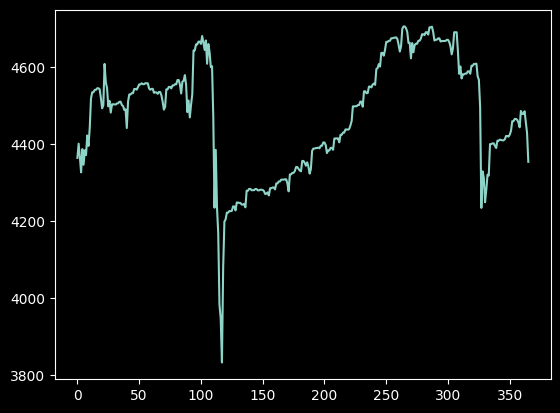

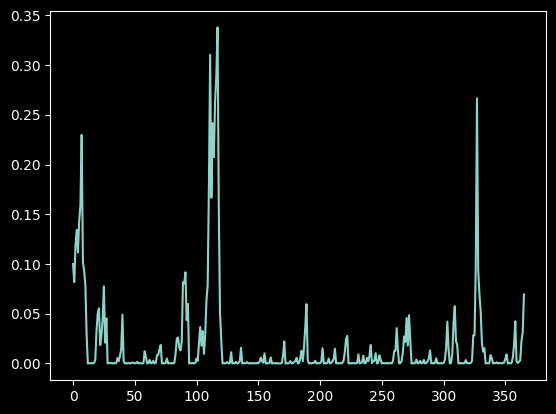

In [33]:
nb.plot_paths(num_show=1)